In [1]:
!pip install opendatasets --quiet

In [2]:
import opendatasets as od

url = "https://www.kaggle.com/competitions/kitchenware-classification/data"
od.download(url)

100%|██████████| 1.63G/1.63G [00:11<00:00, 153MB/s]



Extracting archive ./kitchenware-classification/kitchenware-classification.zip to ./kitchenware-classification


In [ ]:
!ls -lh kitchenware-classification/

total 392K
drwxr-xr-x 2 root root 256K Dec 10 23:11 images
-rw-r--r-- 1 root root  43K Dec 10 23:11 sample_submission.csv
-rw-r--r-- 1 root root  23K Dec 10 23:11 test.csv
-rw-r--r-- 1 root root  63K Dec 10 23:11 train.csv


In [ ]:
import os

len(os.listdir("./kitchenware-classification/images/"))

9367

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Activation,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.models import Model
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [4]:
def append_ext(fp):
  return fp + ".jpg"

In [5]:
train_df = pd.read_csv("./kitchenware-classification/train.csv", dtype=str)
test_df = pd.read_csv("./kitchenware-classification/test.csv", dtype=str)
submit_df = pd.read_csv("./kitchenware-classification/sample_submission.csv")

In [ ]:
train_df.head()

,Id,label
0,0560,glass
1,4675,cup
2,0875,glass
3,4436,spoon
4,8265,plate


In [ ]:
test_df.head()

,Id
0,0678
1,3962
2,9271
3,5133
4,8842


In [6]:
train_df["Id"] = train_df["Id"].apply(append_ext)
test_df["Id"] = test_df["Id"].apply(append_ext)

In [ ]:
train_df.head()

,Id,label
0,0560.jpg,glass
1,4675.jpg,cup
2,0875.jpg,glass
3,4436.jpg,spoon
4,8265.jpg,plate


In [ ]:
train_df.shape

(5559, 2)

In [ ]:
test_df.head()

,Id
0,0678.jpg
1,3962.jpg
2,9271.jpg
3,5133.jpg
4,8842.jpg


In [ ]:
test_df.shape

(3808, 1)

In [7]:
# Preprocess data
datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25
)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [8]:
# Import data from dataframes and directories and turn it into batches
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(32,32)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(32,32)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(32,32)
)

Found 4170 validated image filenames belonging to 6 classes.
Found 1389 validated image filenames belonging to 6 classes.
Found 3808 validated image filenames.


In [ ]:
# Set the seed
tf.random.set_seed(42)

# Create the model
model_1 = Sequential([
    Conv2D(32, (3, 3), padding="same", input_shape=(32, 32, 3)),
    Activation("relu"),

    Conv2D(32, (3, 3)),
    Activation("relu"),
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Conv2D(64, (3, 3), padding="same"),
    Activation("relu"),

    Conv2D(64, (3, 3)),
    Activation("relu"),
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Flatten(),

    Dense(512),
    Activation("relu"),
    Dropout(.5),
    Dense(6, activation="softmax"),
])

# Compile the model
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.experimental.RMSprop(
        learning_rate=0.0001,
        # decay=1e-6
    ),
    metrics=["accuracy"]
)

# Fitting the model
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_1 = model_1.fit(
    train_generator,
    epochs=25,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
)

Epoch 1/25
130/130 [==============================] - 64s 480ms/step - loss: 1.7371 - accuracy: 0.2516 - val_loss: 1.6576 - val_accuracy: 0.3699
Epoch 2/25
130/130 [==============================] - 55s 426ms/step - loss: 1.5440 - accuracy: 0.4036 - val_loss: 1.4416 - val_accuracy: 0.4688
Epoch 3/25
130/130 [==============================] - 56s 431ms/step - loss: 1.4097 - accuracy: 0.4514 - val_loss: 1.3498 - val_accuracy: 0.4724
Epoch 4/25
130/130 [==============================] - 63s 483ms/step - loss: 1.3310 - accuracy: 0.4780 - val_loss: 1.2877 - val_accuracy: 0.4906
Epoch 5/25
130/130 [==============================] - 55s 426ms/step - loss: 1.2705 - accuracy: 0.4930 - val_loss: 1.2454 - val_accuracy: 0.5247
Epoch 6/25
130/130 [==============================] - 63s 485ms/step - loss: 1.2236 - accuracy: 0.5147 - val_loss: 1.1969 - val_accuracy: 0.5407
Epoch 7/25
130/130 [==============================] - 62s 480ms/step - loss: 1.1813 - accuracy: 0.5317 - val_loss: 1.1635 - val_ac

In [ ]:
# Evaluate the model

score = model_1.evaluate(valid_generator, verbose=0)
print(f"Test loss  :  {score[0]:4.4f}")
print(f"Test accuracy  :  {100*score[1]:4.4f}%")

Test loss  :  0.8718
Test accuracy  :  67.0266%


In [ ]:
df_model1 = pd.DataFrame(history_1.history)
df_model1.head()

,loss,accuracy,val_loss,val_accuracy
0,1.737089,0.251571,1.657586,0.369913
1,1.543983,0.403577,1.441642,0.468750
2,1.409703,0.451426,1.349771,0.472384
3,1.330986,0.478009,1.287675,0.490552
4,1.270456,0.492992,1.245392,0.524709


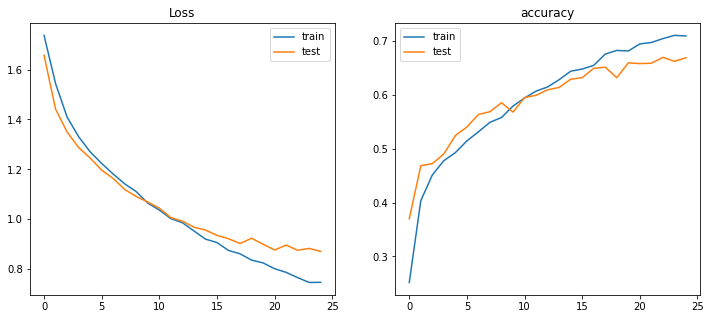

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model1)), df_model1.loss, label="train")
plt.plot(range(len(df_model1)), df_model1.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model1)), df_model1.accuracy, label="train")
plt.plot(range(len(df_model1)), df_model1.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

In [ ]:
# Predict the output
test_generator.reset()

y_softmax = model_1.predict(
    test_generator,
    steps=STEP_SIZE_SET,
    verbose=1,
)

119/119 [==============================] - 45s 374ms/step


In [ ]:
y_preds = np.argmax(y_softmax, axis=-1)

In [ ]:
y_preds

array([1, 3, 2, ..., 1, 5, 5])

In [ ]:
cm = confusion_matrix(y_true=valid_generator, y_pred=y_preds)

ValueError: ignored

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_preds]

In [ ]:
predictions

['fork',
 'knife',
 'glass',
 'plate',
 'spoon',
 'fork',
 'fork',
 'glass',
 'knife',
 'cup',
 'plate',
 'glass',
 'knife',
 'plate',
 'fork',
 'plate',
 'fork',
 'cup',
 'knife',
 'plate',
 'knife',
 'spoon',
 'glass',
 'plate',
 'plate',
 'cup',
 'knife',
 'spoon',
 'glass',
 'fork',
 'plate',
 'cup',
 'cup',
 'cup',
 'spoon',
 'plate',
 'cup',
 'plate',
 'plate',
 'spoon',
 'plate',
 'glass',
 'plate',
 'plate',
 'knife',
 'spoon',
 'spoon',
 'cup',
 'cup',
 'spoon',
 'plate',
 'cup',
 'knife',
 'plate',
 'cup',
 'glass',
 'knife',
 'cup',
 'cup',
 'cup',
 'plate',
 'knife',
 'knife',
 'spoon',
 'plate',
 'spoon',
 'cup',
 'spoon',
 'cup',
 'fork',
 'cup',
 'cup',
 'knife',
 'plate',
 'cup',
 'cup',
 'knife',
 'spoon',
 'knife',
 'knife',
 'spoon',
 'cup',
 'plate',
 'cup',
 'knife',
 'knife',
 'plate',
 'glass',
 'glass',
 'knife',
 'knife',
 'spoon',
 'knife',
 'spoon',
 'glass',
 'glass',
 'spoon',
 'fork',
 'spoon',
 'cup',
 'spoon',
 'plate',
 'spoon',
 'cup',
 'plate',
 'spoo

In [ ]:
filenames = test_generator.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

---

In [10]:
# Model 2
# Set the seed
tf.random.set_seed(42)

# Create the model
model_2 = Sequential([
    Conv2D(96, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(192, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(1500, activation='relu'),
    Dropout(0.5),

    Dense(6, activation="softmax"),
])

# Compile the model
model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"]
)

# Fitting the model
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_2 = model_2.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
)

Epoch 1/10
130/130 [==============================] - 60s 456ms/step - loss: 1.5007 - accuracy: 0.4058 - val_loss: 1.1619 - val_accuracy: 0.5443
Epoch 2/10
130/130 [==============================] - 65s 503ms/step - loss: 1.0836 - accuracy: 0.5752 - val_loss: 1.0206 - val_accuracy: 0.6083
Epoch 3/10
130/130 [==============================] - 68s 526ms/step - loss: 0.9431 - accuracy: 0.6206 - val_loss: 0.9673 - val_accuracy: 0.6192
Epoch 4/10
130/130 [==============================] - 69s 529ms/step - loss: 0.8400 - accuracy: 0.6752 - val_loss: 0.9293 - val_accuracy: 0.6468
Epoch 5/10
130/130 [==============================] - 64s 497ms/step - loss: 0.7626 - accuracy: 0.7086 - val_loss: 0.9364 - val_accuracy: 0.6417
Epoch 6/10
130/130 [==============================] - 66s 511ms/step - loss: 0.6729 - accuracy: 0.7528 - val_loss: 0.8717 - val_accuracy: 0.6613
Epoch 7/10
130/130 [==============================] - 64s 493ms/step - loss: 0.5577 - accuracy: 0.7835 - val_loss: 0.8947 - val_ac

In [11]:
max_val_accuracy = max(history_2.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.6679


In [12]:
score = model_2.evaluate(valid_generator, verbose=0)
print(f"Test loss  :  {score[0]:5.4f}")
print(f"Test accuracy  :  {100*score[1]:5.4f}%")

Test loss  :  1.0553
Test accuracy  :  66.7387%


In [13]:
df_model2 = pd.DataFrame(history_2.history)
df_model2.head()

,loss,accuracy,val_loss,val_accuracy
0,1.500745,0.405752,1.161938,0.544331
1,1.083569,0.575157,1.020649,0.608285
2,0.943113,0.620590,0.967274,0.619186
3,0.839996,0.675205,0.929292,0.646802
4,0.762564,0.708555,0.936393,0.641715


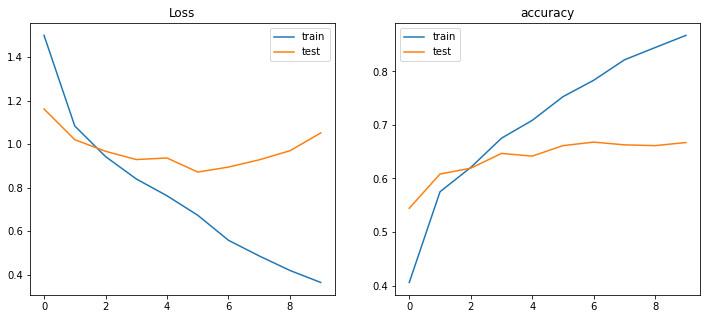

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model2)), df_model2.loss, label="train")
plt.plot(range(len(df_model2)), df_model2.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model2)), df_model2.accuracy, label="train")
plt.plot(range(len(df_model2)), df_model2.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

---

In [15]:
# Model 3
# Set the seed
tf.random.set_seed(42)

# Create the model
model_3 = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(32,32,3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), padding='same', activation='relu'),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), padding='same',activation='relu'),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(6, activation="softmax"),
])

# Compile the model
model_3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"]
)

# Fitting the model
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_3 = model_3.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
)

Epoch 1/10
130/130 [==============================] - 65s 490ms/step - loss: 1.7327 - accuracy: 0.2467 - val_loss: 1.6787 - val_accuracy: 0.3445
Epoch 2/10
130/130 [==============================] - 63s 487ms/step - loss: 1.5808 - accuracy: 0.3652 - val_loss: 1.3814 - val_accuracy: 0.4440
Epoch 3/10
130/130 [==============================] - 68s 526ms/step - loss: 1.2828 - accuracy: 0.4693 - val_loss: 1.1341 - val_accuracy: 0.5523
Epoch 4/10
130/130 [==============================] - 66s 509ms/step - loss: 1.1092 - accuracy: 0.5452 - val_loss: 0.9884 - val_accuracy: 0.6199
Epoch 5/10
130/130 [==============================] - 64s 486ms/step - loss: 0.9788 - accuracy: 0.5981 - val_loss: 0.9177 - val_accuracy: 0.6475
Epoch 6/10
130/130 [==============================] - 58s 445ms/step - loss: 0.8874 - accuracy: 0.6426 - val_loss: 0.9057 - val_accuracy: 0.6592
Epoch 7/10
130/130 [==============================] - 62s 479ms/step - loss: 0.7937 - accuracy: 0.6757 - val_loss: 0.8403 - val_ac

In [16]:
max_val_accuracy = max(history_3.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.7173


In [17]:
score = model_3.evaluate(valid_generator, verbose=0)
print(f"Test loss  :  {score[0]:5.4f}")
print(f"Test accuracy  :  {100*score[1]:5.4f}%")

Test loss  :  0.7926
Test accuracy  :  71.7063%


In [18]:
df_model3 = pd.DataFrame(history_3.history)
df_model3.head()

,loss,accuracy,val_loss,val_accuracy
0,1.732685,0.246738,1.678672,0.344477
1,1.580802,0.365152,1.381382,0.444041
2,1.282797,0.469309,1.134081,0.552326
3,1.109195,0.545191,0.988356,0.619913
4,0.978786,0.598115,0.917658,0.647529


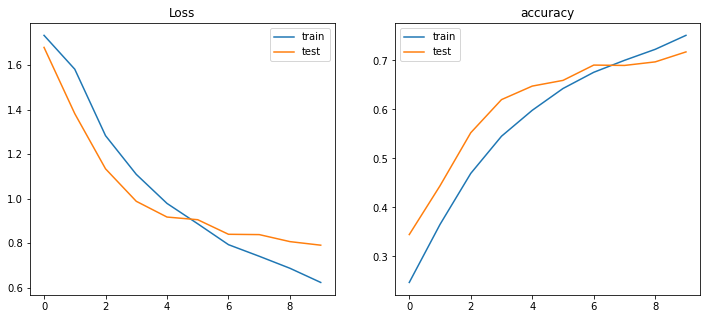

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model3)), df_model3.loss, label="train")
plt.plot(range(len(df_model3)), df_model3.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model3)), df_model3.accuracy, label="train")
plt.plot(range(len(df_model3)), df_model3.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

---

In [7]:
# data augmentation
augmented_datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25,
    featurewise_center=False,
    featurewise_std_normalization=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10.
)

In [8]:
# Import data from dataframes and directories and turn it into batches
augmented_train_generator = augmented_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(32,32)
)

augmented_valid_generator = augmented_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(32,32)
)

Found 4170 validated image filenames belonging to 6 classes.
Found 1389 validated image filenames belonging to 6 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255.)

In [12]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(32,32)
)

Found 3808 validated image filenames.


In [18]:
# Model 4 Augmented
# Set the seed
tf.random.set_seed(42)

# Create the model
model_4 = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(32,32,3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), padding='same', activation='relu'),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), padding='same',activation='relu'),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(6, activation="softmax"),
])

# Compile the model
model_4.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"]
)

# Fitting the model
STEP_SIZE_TRAIN = augmented_train_generator.n // augmented_train_generator.batch_size
STEP_SIZE_VALID = augmented_valid_generator.n // augmented_valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_4 = model_4.fit(
    augmented_train_generator,
    epochs=25,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=augmented_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
)

Epoch 1/25
130/130 [==============================] - 60s 454ms/step - loss: 1.7671 - accuracy: 0.2221 - val_loss: 1.7110 - val_accuracy: 0.2580
Epoch 2/25
130/130 [==============================] - 59s 454ms/step - loss: 1.6599 - accuracy: 0.2987 - val_loss: 1.6006 - val_accuracy: 0.3706
Epoch 3/25
130/130 [==============================] - 59s 453ms/step - loss: 1.5429 - accuracy: 0.3784 - val_loss: 1.4055 - val_accuracy: 0.4259
Epoch 4/25
130/130 [==============================] - 60s 459ms/step - loss: 1.3705 - accuracy: 0.4427 - val_loss: 1.2736 - val_accuracy: 0.4673
Epoch 5/25
130/130 [==============================] - 64s 494ms/step - loss: 1.2696 - accuracy: 0.4727 - val_loss: 1.2220 - val_accuracy: 0.5174
Epoch 6/25
130/130 [==============================] - 58s 446ms/step - loss: 1.1669 - accuracy: 0.5280 - val_loss: 1.1420 - val_accuracy: 0.5741
Epoch 7/25
130/130 [==============================] - 58s 450ms/step - loss: 1.1021 - accuracy: 0.5631 - val_loss: 1.0364 - val_ac

In [19]:
max_val_accuracy = max(history_4.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.6955


In [20]:
score = model_4.evaluate(augmented_valid_generator, verbose=0)
print(f"Test loss  :  {score[0]:5.4f}")
print(f"Test accuracy  :  {100*score[1]:5.4f}%")

Test loss  :  0.7995
Test accuracy  :  68.8265%


In [21]:
df_model4 = pd.DataFrame(history_4.history)
df_model4.head()

,loss,accuracy,val_loss,val_accuracy
0,1.767060,0.222088,1.711040,0.257994
1,1.659865,0.298695,1.600607,0.370640
2,1.542931,0.378444,1.405452,0.425872
3,1.370524,0.442726,1.273561,0.467297
4,1.269646,0.472692,1.221981,0.517442


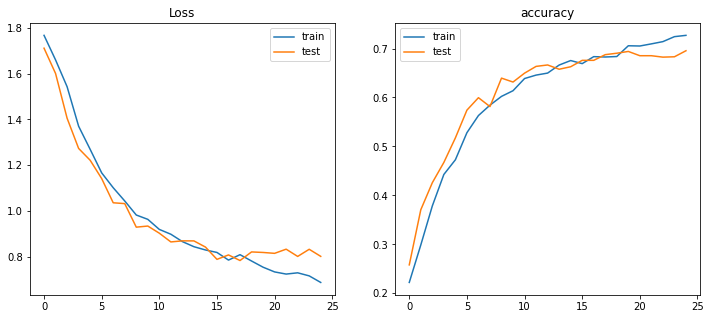

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model4)), df_model4.loss, label="train")
plt.plot(range(len(df_model4)), df_model4.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model4)), df_model4.accuracy, label="train")
plt.plot(range(len(df_model4)), df_model4.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

---

In [7]:
# transfer learning

# Preprocess data
datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25
)

test_datagen = ImageDataGenerator(rescale=1./255.)

# Import data from dataframes and directories and turn it into batches
tl_train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

tl_valid_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(224,224)
)

Found 4170 validated image filenames belonging to 6 classes.
Found 1389 validated image filenames belonging to 6 classes.
Found 3808 validated image filenames.


In [8]:
base_model = vgg16.VGG16(
    weights = "imagenet", 
    include_top=False,
    input_shape = (224,224, 3), 
    pooling="avg"
)

for layer in base_model.layers[:-5]:
  layer.trainable = False

last_output = base_model.output

x = Dense(6, activation="softmax")(last_output)
# inputs = keras.Input(shape=(224, 224, 3))
model_5 = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"]
)

# Fitting the model
STEP_SIZE_TRAIN = tl_train_generator.n // tl_train_generator.batch_size
STEP_SIZE_VALID = tl_valid_generator.n // tl_valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_5 = model_5.fit(
    tl_train_generator,
    epochs=25,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=tl_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/25
130/130 [==============================] - 80s 540ms/step - loss: 1.2299 - accuracy: 0.4814 - val_loss: 0.6694 - val_accuracy: 0.7500
Epoch 2/25
130/130 [==============================] - 70s 535ms/step - loss: 0.5300 - accuracy: 0.8076 - val_loss: 0.6365 - val_accuracy: 0.7914
Epoch 3/25
130/130 [==============================] - 69s 534ms/step - loss: 0.3249 - accuracy: 0.8842 - val_loss: 0.3892 - val_accuracy: 0.8721
Epoch 4/25
130/130 [==============================] - 69s 534ms/step - loss: 0.2309 - accuracy: 0.9241 - val_loss: 0.3317 - val_accuracy: 0.9055
Epoch 5/25
130/130 [==============================] - 71s 542ms/step - loss: 0.1773 - accuracy: 0.9393 - val_loss: 0.3799 - val_accuracy: 0.8859
Epoch 6/25
130/130 [==============================] - 69s 528ms/step - loss: 0.1502 - accuracy: 0.9519 - val_loss: 0.3406 - val_accuracy: 0.8946
Epoch 7/25
130/130 [==============================] - 69s 532ms/s

In [9]:
max_val_accuracy = max(history_5.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9259


In [10]:
score = model_5.evaluate(tl_valid_generator, verbose=0)
print(f"Test loss  :  {score[0]:5.4f}")
print(f"Test accuracy  :  {100*score[1]:5.4f}%")

Test loss  :  0.7966
Test accuracy  :  92.1526%


In [11]:
df_model5 = pd.DataFrame(history_5.history)
df_model5.head()

,loss,accuracy,val_loss,val_accuracy
0,1.229888,0.481392,0.669436,0.750000
1,0.529985,0.807637,0.636488,0.791424
2,0.324852,0.884244,0.389180,0.872093
3,0.230915,0.924118,0.331717,0.905523
4,0.177299,0.939343,0.379851,0.885901


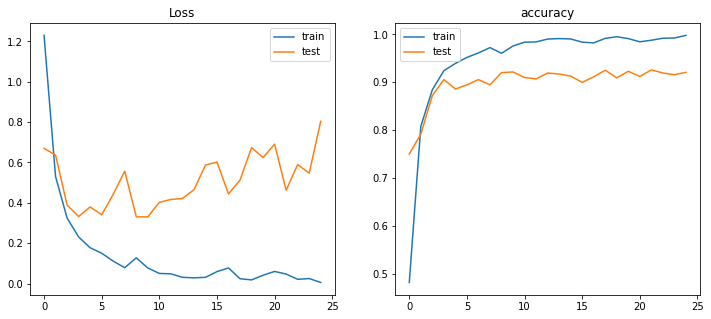

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model5)), df_model5.loss, label="train")
plt.plot(range(len(df_model5)), df_model5.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model5)), df_model5.accuracy, label="train")
plt.plot(range(len(df_model5)), df_model5.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

---

In [14]:
base_model = vgg16.VGG16(
    weights = "imagenet", 
    include_top=False,
    input_shape = (224,224, 3), 
    pooling="avg"
)

for layer in base_model.layers[:-5]:
  layer.trainable = False

last_output = base_model.output
x = Dense(6, activation="softmax")(last_output)

model_6 = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_6.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"]
)

# Create a learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

# Fitting the model
STEP_SIZE_TRAIN = tl_train_generator.n // tl_train_generator.batch_size
STEP_SIZE_VALID = tl_valid_generator.n // tl_valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_6 = model_6.fit(
    tl_train_generator,
    epochs=10,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=tl_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
    callbacks=[lr_scheduler],
)

Epoch 1/10
130/130 [==============================] - 72s 550ms/step - loss: 0.6460 - accuracy: 0.7743 - val_loss: 0.3972 - val_accuracy: 0.8663 - lr: 1.0000e-04
Epoch 2/10
130/130 [==============================] - 70s 537ms/step - loss: 0.2877 - accuracy: 0.9014 - val_loss: 0.3357 - val_accuracy: 0.8801 - lr: 1.1220e-04
Epoch 3/10
130/130 [==============================] - 69s 529ms/step - loss: 0.1852 - accuracy: 0.9391 - val_loss: 0.2923 - val_accuracy: 0.8917 - lr: 1.2589e-04
Epoch 4/10
130/130 [==============================] - 69s 527ms/step - loss: 0.1148 - accuracy: 0.9613 - val_loss: 0.2768 - val_accuracy: 0.9092 - lr: 1.4125e-04
Epoch 5/10
130/130 [==============================] - 70s 536ms/step - loss: 0.0915 - accuracy: 0.9691 - val_loss: 0.2539 - val_accuracy: 0.9273 - lr: 1.5849e-04
Epoch 6/10
130/130 [==============================] - 70s 535ms/step - loss: 0.0997 - accuracy: 0.9647 - val_loss: 0.2238 - val_accuracy: 0.9339 - lr: 1.7783e-04
Epoch 7/10
130/130 [========

In [15]:
max_val_accuracy = max(history_6.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9339


In [18]:
df_model6 = pd.DataFrame(history_6.history)
df_model6.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.646027,0.774287,0.397239,0.866279,0.000100
1,0.287681,0.901402,0.335744,0.880087,0.000112
2,0.185227,0.939101,0.292342,0.891715,0.000126
3,0.114768,0.961334,0.276770,0.909157,0.000141
4,0.091499,0.969067,0.253901,0.927326,0.000158


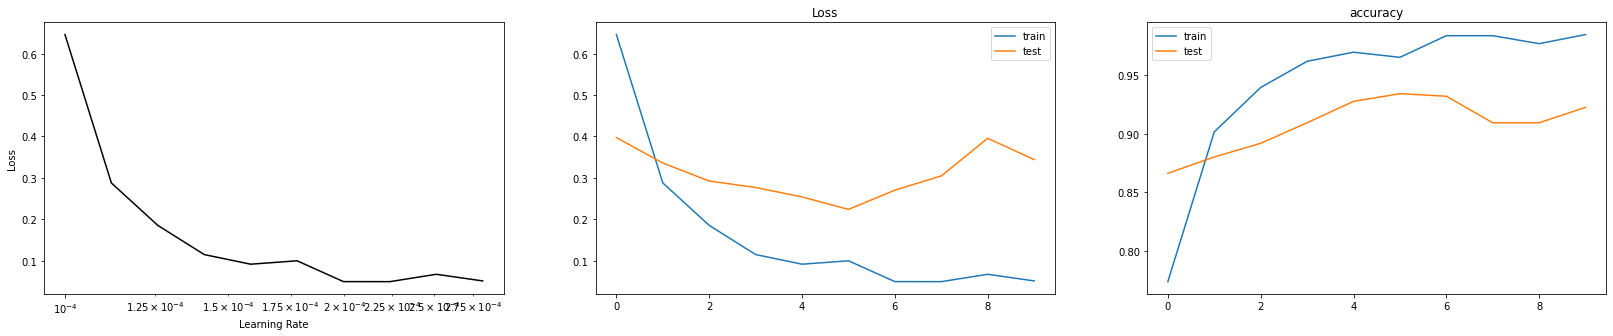

In [20]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(28, 5))
plt.subplot(1, 3, 1)
plt.semilogx(df_model6.lr, df_model6["loss"], c="k") # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.subplot(1, 3, 2)
plt.plot(range(len(df_model6)), df_model6.loss, label="train")
plt.plot(range(len(df_model6)), df_model6.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(range(len(df_model6)), df_model6.accuracy, label="train")
plt.plot(range(len(df_model6)), df_model6.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()
